In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
trans_df = pd.read_csv('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';', encoding = 'utf-8')
#Type_List = ['COL', 'RET']
#trans_df = trans_df.loc[trans_df['T_DOC_TYPE'].isin(Type_List)]
trans_df = trans_df.loc[trans_df['T_DOC_TYPE'] == 'COL']

trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.dropna(subset = ['Date'])

trans_df = trans_df[['Date', 'T_DOC_TYPE', 'T_SENDING_ID', 'T_RTI_NAME', 'T_ACT_HAND_OUT_QTY']]
trans_df = trans_df.reset_index()
trans_df = trans_df.drop('index', axis = 1)
#trans_df.head()

In [3]:
depot_add = pd.read_excel('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
depot_add = depot_add[['name', 'code', 'country']]
#depot_add.head()

In [4]:
# JOIN

trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop(['T_SENDING_ID', 'T_DOC_TYPE'], axis =1)
trans_full.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name,country
0,2014-12-22,CC Euro Container Base,60,NL-Bleiswijk-CCNL,NL
1,2014-12-22,CC Euro Container Post 170,240,NL-Bleiswijk-CCNL,NL
2,2014-07-09,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL
3,2014-07-09,CC Container Shelf,30,NL-Bleiswijk Bloemenveiling Holland,NL
4,2014-07-04,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL


# Filter Dataset:

### _ONLY NL

In [5]:

trans_nl = trans_full.loc[trans_full['country'] == 'NL']
trans_nl = trans_nl.sort_values('Date', ascending = True)
trans_nl = trans_nl.drop(['country'], axis = 1)
trans_nl.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name
40927,2014-07-01,CBL 7,3250,NL-Zwaagdijk Vijn
2502,2014-07-01,CBL 7,3000,NL-Zwaagdijk Vijn
4766,2014-07-01,Chep blok,26,NL-Zwaagdijk Vijn
1709,2014-07-01,CBL 7,3250,NL-Zwaagdijk Vijn
1708,2014-07-01,CBL 7,3250,NL-Zwaagdijk Vijn


### _RTI = Container Base

In [6]:
nl_cb = trans_nl.loc[trans_nl['T_RTI_NAME'] == 'CC Container Base']
nl_cb = nl_cb.drop(['T_RTI_NAME'], axis = 1)
nl_cb['Date'] = pd.to_datetime(nl_cb['Date'])
nl_cb = nl_cb.set_index('Date')
nl_cb

,T_ACT_HAND_OUT_QTY,name
Date,,
2014-07-04,32,NL-Bleiswijk Bloemenveiling Holland
2014-07-04,37,NL-Bleiswijk Bloemenveiling Holland
2014-07-04,25,NL-Bleiswijk Bloemenveiling Holland
2014-07-04,4,NL-Bleiswijk Bloemenveiling Holland
2014-07-04,50,NL-Bleiswijk Bloemenveiling Holland
...,...,...
2019-07-04,30,NL-Bleiswijk Bloemenveiling Holland
2019-07-04,61,NL-Bleiswijk Bloemenveiling Holland
2019-07-05,26,NL-Hazerswoude-CCNL


Text(0.5, 1.0, 'CB_IT Jul 2014--Jul 2019')

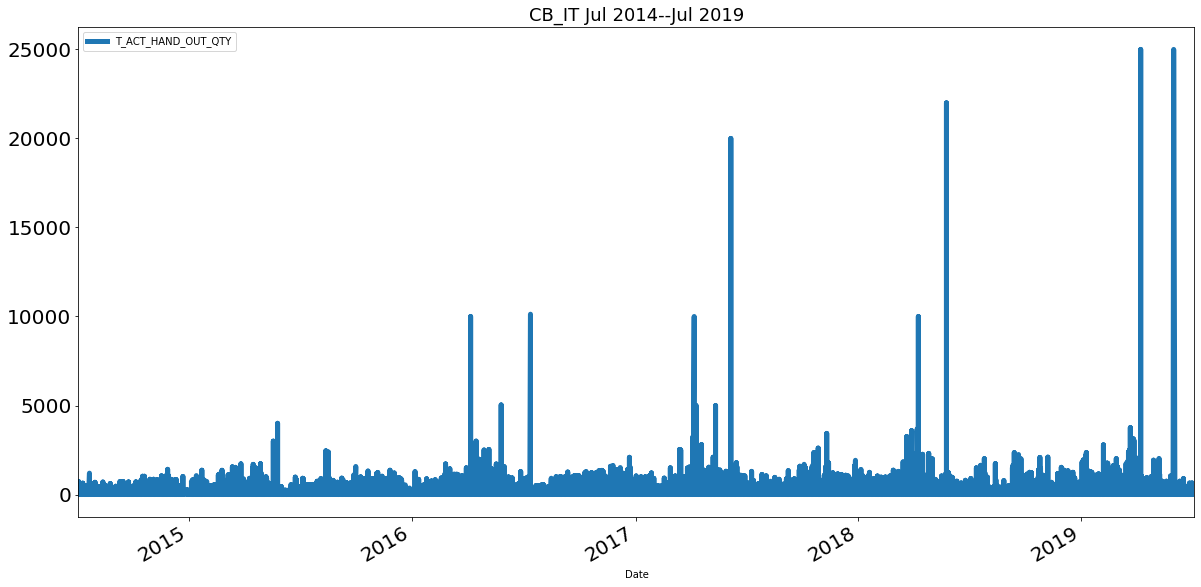

In [7]:
nl_cb.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title("CB_IT Jul 2014--Jul 2019", fontsize = 18)

## Monthly from 2016 on

Text(0.5, 1.0, 'CB_IT : Jan 2016--Jul 2019')

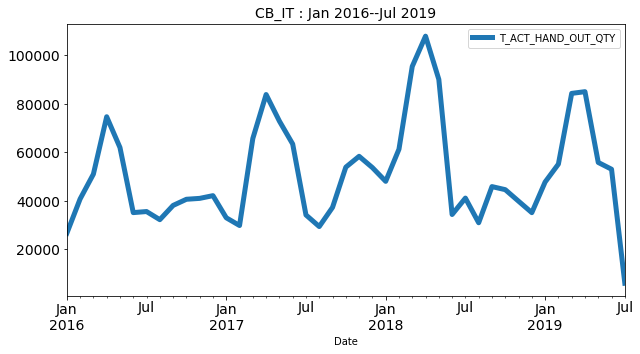

In [8]:
import datetime
nl_cbm = nl_cb.resample('1M').sum()
nl_cb_m = nl_cbm[(nl_cbm.index >= datetime.datetime(2016,1,31))]
nl_cb_m.plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title("CB_IT : Jan 2016--Jul 2019", fontsize = 14)

## Seasonal Decompose 2016

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
result = seasonal_decompose(nl_cb_m, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

Text(0.5, 1.0, 'Residual')

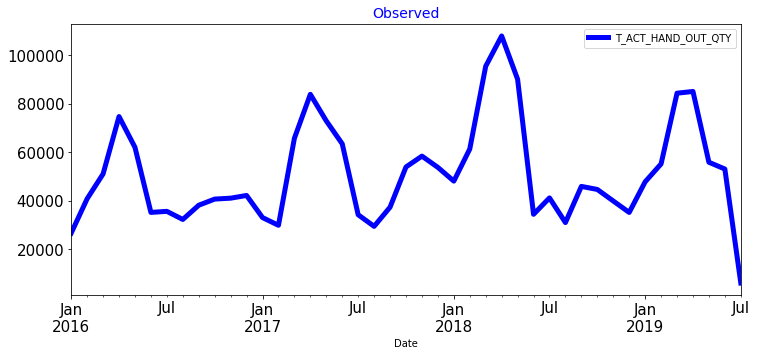

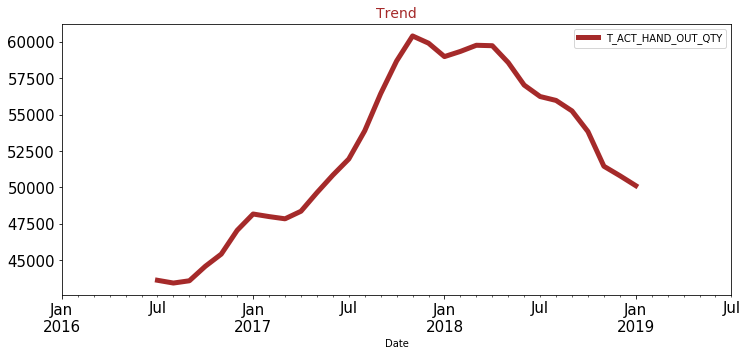

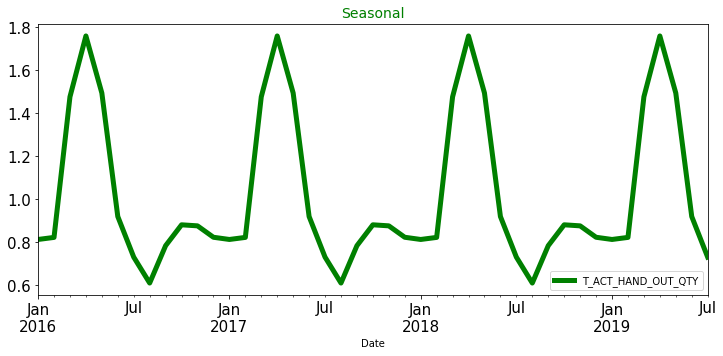

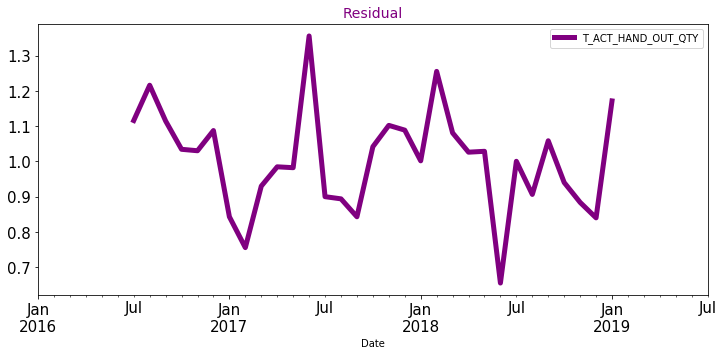

In [10]:
result.observed.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'blue')
plt.title('Observed', fontsize = 14, color ='blue')

result.trend.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'brown')
plt.title('Trend', fontsize = 14 , color = 'brown')

result.seasonal.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'green')
plt.title('Seasonal', fontsize = 14 , color = 'green')

result.resid.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'purple')
plt.title('Residual', fontsize = 14 , color = 'purple')

## SARIMA

In [11]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
stepwise_model = arima.auto_arima(nl_cb_m, start_p=1, start_q=1,
                           max_p=6, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=685.738, BIC=688.541, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=673.002, BIC=678.607, Fit time=0.072 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=684.034, BIC=685.436, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=681.912, BIC=686.116, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=674.936, BIC=681.942, Fit time=0.183 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=na

In [12]:
#it_cb_m.index

In [13]:
train = nl_cb_m.loc['2016-01-31':'2018-12-31']
test = nl_cb_m.loc['2019-01-31':]

In [14]:
model_fit = stepwise_model.fit(train)
model_fit

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [15]:
future_forecast = stepwise_model.predict(n_periods=7)
future_forecast

array([33283.63968188, 35297.26180383, 68149.35785848, 81482.22494447,
       65180.44647552, 32584.44785049, 17401.05640642])

Text(0.5, 1.0, '2019 Prediction of FR-CB')

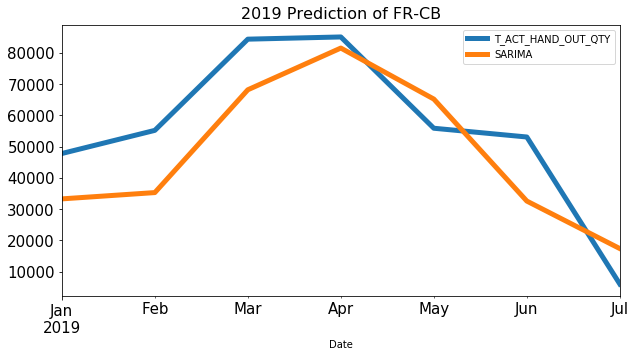

In [16]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['SARIMA'])
pd.concat([test,future_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of FR-CB', fontsize = 16)

In [17]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, future_forecast)
mse

216345287.09110424

In [18]:
model_fit.aic

<function pmdarima.arima.arima.ARIMA.aic(self)>

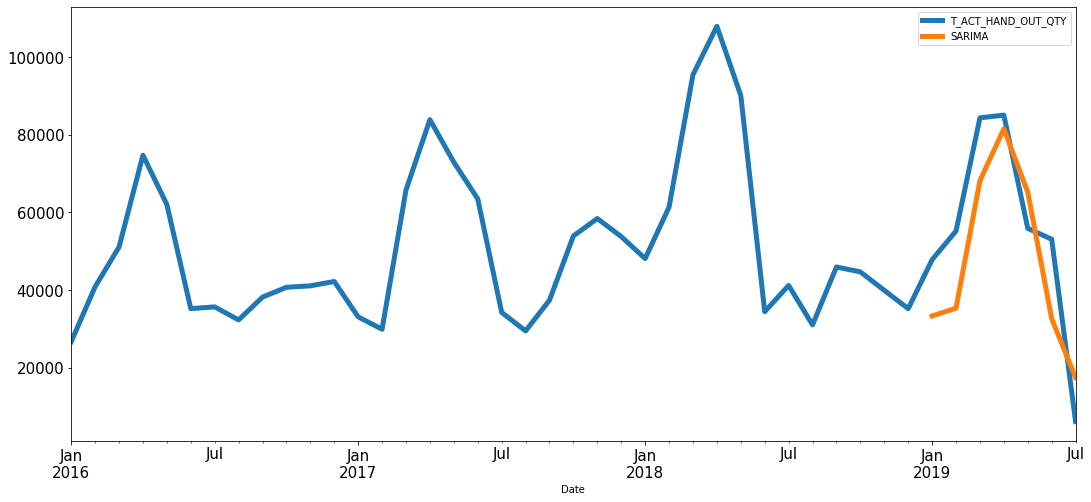

In [19]:
pd.concat([nl_cb_m,future_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)

## ARIMA

In [20]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
arima_model = arima.auto_arima(nl_cb_m, start_p=0, start_q=0,
                           max_p=5, max_q=5,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(arima_model.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=948.777, BIC=952.252, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=948.247, BIC=953.460, Fit time=0.011 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=948.093, BIC=953.306, Fit time=0.012 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=946.818, BIC=948.556, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=950.026, BIC=956.977, Fit time=0.028 seconds
Total fit time: 0.067 seconds
946.8180753300524


In [21]:
arima_fit = arima_model.fit(train)

In [22]:
arima_forecast = arima_fit.predict(n_periods=7)
arima_forecast

array([35170., 35170., 35170., 35170., 35170., 35170., 35170.])

Text(0.5, 1.0, '2019 Prediction of NL-CB')

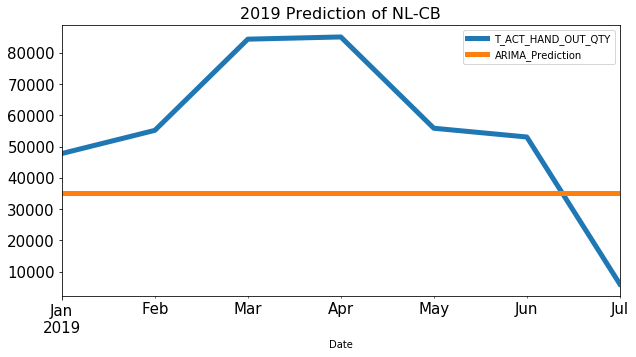

In [23]:
arima_forecast = pd.DataFrame(arima_forecast,index = test.index,columns=['ARIMA_Prediction'])
pd.concat([test,arima_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of NL-CB', fontsize = 16)

Text(0.5, 1.0, '2019 (non-diff) Prediction of FR-CB')

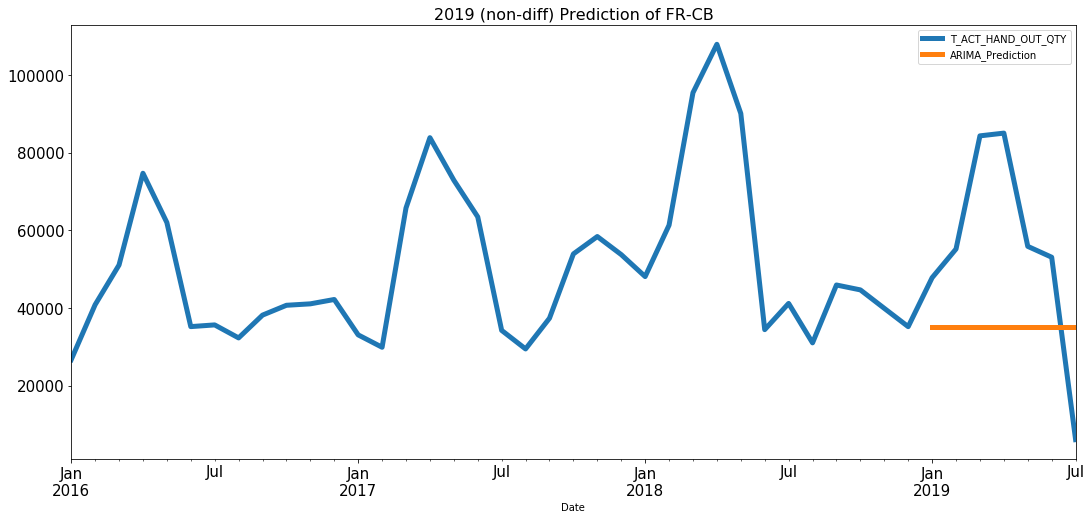

In [24]:
pd.concat([nl_cb_m, arima_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)
plt.title('2019 (non-diff) Prediction of FR-CB', fontsize = 16)

## d&D = 0

In [25]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
nodiff_model = arima.auto_arima(nl_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(nodiff_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=963.529, BIC=972.335, Fit time=0.074 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=981.512, BIC=985.034, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=961.345, BIC=968.390, Fit time=0.100 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=965.469, BIC=972.513, Fit time=0.050 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=1063.094, BIC=1064.856, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=965.693, BIC=970.976, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=962.555, BIC=971.361, Fit time=0.122 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=963.263, BIC=972.069, Fit time=0.073 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=963.223, BIC=970.268, Fit time=0.036 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2

In [26]:
nodiff_fit = nodiff_model.fit(train)

In [27]:
nondiff_forecast = nodiff_fit.predict(n_periods=7)
nondiff_forecast

array([41541.66441242, 49558.40493307, 54594.10503144, 55224.50110678,
       52973.73529231, 50223.74924388, 48620.54124741])

Text(0.5, 1.0, '2019 Prediction of NL-CB')

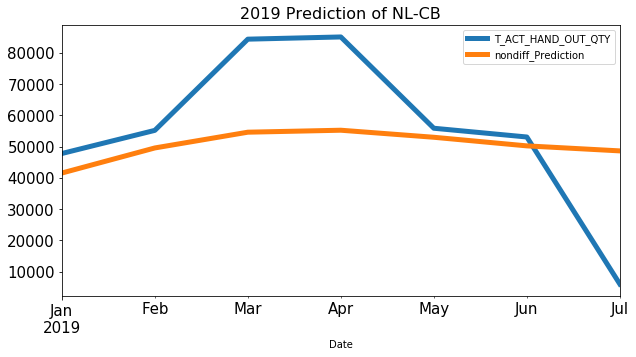

In [28]:
nondiff_forecast = pd.DataFrame(nondiff_forecast,index = test.index,columns=['nondiff_Prediction'])
pd.concat([test,nondiff_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of NL-CB', fontsize = 16)

In [29]:
nondiff_mse = mean_squared_error(test, nondiff_forecast)
nondiff_mse

524296752.4096466

Text(0.5, 1.0, '2019 (non-diff) Prediction of NL-CB')

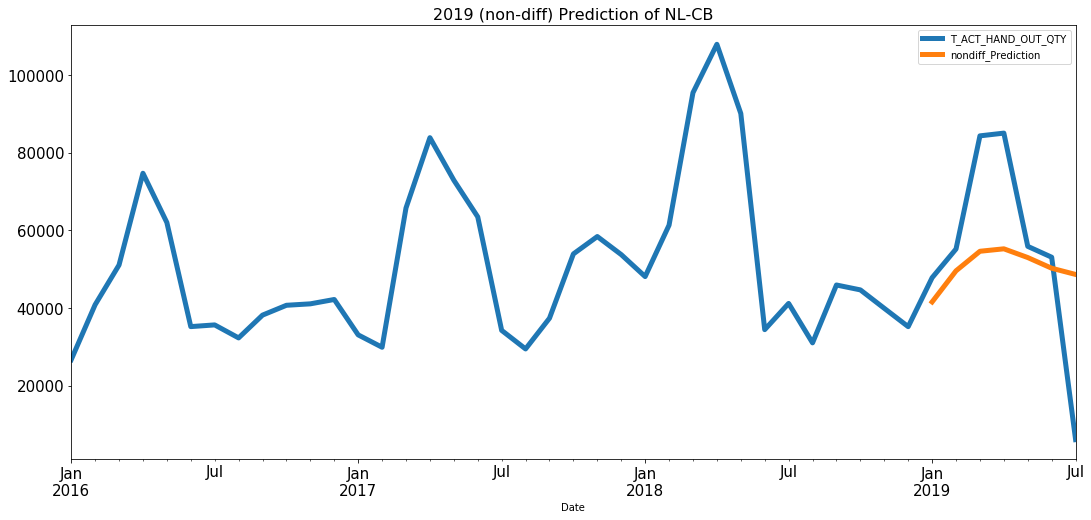

In [30]:
pd.concat([nl_cb_m,nondiff_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)
plt.title('2019 (non-diff) Prediction of NL-CB', fontsize = 16)

## Comparison

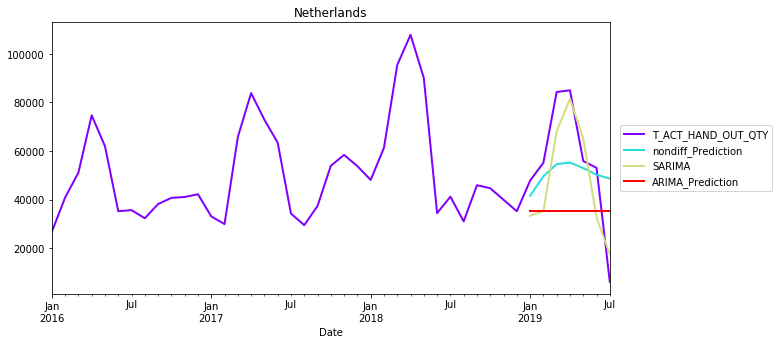

In [31]:
pd.concat([nl_cb_m, nondiff_forecast, future_forecast, arima_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='Netherlands')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [32]:
MSEs = [mse, nondiff_mse, all_mse]

NameError: name 'all_mse' is not defined

In [ ]:
norm = [i/sum(MSEs) for i in MSEs]
norm

In [ ]:
MSEs.index(min(MSEs))

In [ ]:
max(MSEs)

In [ ]:
mse

In [ ]:
from math import sqrt
sqrt(mse)

In [ ]:
nondiff_mse

In [ ]:
sqrt(nondiff_mse)

In [ ]:
all_mse

In [ ]:
sqrt(all_mse)

## DEPOTS

In [ ]:
trans_fr = trans_it
trans_fr['Date'] = pd.to_datetime(trans_fr['Date'])

In [ ]:
(trans_fr.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY']
   .sum()
   .unstack('name', fill_value=0)
   .plot(figsize=(20,10), linewidth=5, fontsize=20))
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Daily', fontsize=20)
plt.show()

In [ ]:
fr_deps = trans_fr.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum().unstack('name', fill_value=0)
fr_deps_month = fr_deps.resample('1M').sum()
fr_deps_month.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Monthly', fontsize=20)
plt.show()

## From 2017 on

In [ ]:
import datetime
fr_cb2016 = fr_deps_month[(it_cbm.index >= datetime.datetime(2016,1,31))]
fr_cb2016.plot(figsize=(20,10), linewidth=5, fontsize=14)
plt.title("CB_FR : Jan 2016--Jul 2019", fontsize = 18)

In [ ]:
depos = trans_fr['name'].unique()

In [ ]:
def optimal_sarima(depot):
    
    stepwise_model = arima.auto_arima(depot, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=6,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    return stepwise_model
    #print(stepwise_model.aic())

In [ ]:
opt_sarima_deps = []
for i in range(0,len(depos)):
    dep = fr_cb2016[[depos[i]]].dropna()
    print('\n ' + depos[i] + ': ')
    print('\n')
    opt_sarima = optimal_sarima(dep)
    print(opt_sarima.aic())
    opt_sarima_deps.append(opt_sarima)

In [ ]:
opt_sarima_deps[0]

In [ ]:
d1 = fr_cb2016[[depos[1]]].dropna()
train1 = d1.loc['2016-01-31':'2018-12-31']
test1 = d1.loc['2019-01-31':]


In [ ]:
dep1_fit = opt_sarima_deps[1].fit(train1)

In [ ]:
dep1_forecast = dep1_fit.predict(n_periods=6)
dep1_forecast

In [ ]:
dep1_forecast = pd.DataFrame(dep1_forecast,index = test.index,columns=[depos[1] + '_Prediction'])
pd.concat([test1,dep1_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title('2019 Prediction of ' + depos[1], fontsize = 14)

In [ ]:
for j in range(0,len(depos)):
    d = fr_cb2016[[depos[i]]].dropna()
    

    print(d.index)

In [ ]:
optimal_test = list()
optimal_prediction = list()
opt_deps_forecast = list()
depo_train = list()
depo_test = list()
mse = list()

for f in range(0, len(depos)):
    dep = fr_cb2016[[depos[f]]].dropna()
    my_train = dep.loc['2016-01-31':'2018-12-31']
    my_test = dep.loc['2019-01-31':]
    
    model_fit = opt_sarima_deps[f].fit(my_train)

    depo_forecast = model_fit.predict(n_periods=6)
    
    for col in range(len(depo_forecast)):
        if depo_forecast[col] < 0:
            depo_forecast[col] = 0
    
    opt_deps_forecast.append(depo_forecast)
    depo_train.append(my_train)
    depo_test.append(my_test)
    



In [ ]:
depo_test

In [ ]:
opt_deps_forecast

In [ ]:
depots_forecasts = pd.DataFrame()

In [ ]:
for i in range(0, len(depos)):
    depots_forecasts[depos[i]] = opt_deps_forecast[i]
    

In [ ]:
my_test

In [ ]:
depots_forecasts['Date'] = my_test.index
depots_forecasts = depots_forecasts.set_index('Date')
depots_forecasts

In [ ]:
def plot_depo_prediction(depo_name, depo_test, depo_pred):
        pd.concat([depo_test, depo_pred], axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
        plt.title('2019 Prediction of ' + depo_name, fontsize = 14)        

In [ ]:
depos_mse = list()
for j in range(0, len(depos)):
    plot_depo_prediction(depos[j], depo_test[j], depots_forecasts[[depos[j]]])
    mse = mean_squared_error(depo_test[j], depots_forecasts[[depos[j]]])
    depos_mse.append(mse)

In [ ]:
depos_mse

In [ ]:
norm = [i/sum(depos_mse) for i in depos_mse]
norm

In [ ]:
print('Normalized MSE of depots: ')
for r in range(0, len(depos)):
    print('\n ' + depos[r] + ' : ' + str(norm[r]))

i = norm.index(min(norm))
print('\n the MOST accurate : ' + depos[i])

j = norm.index(max(norm))
print('\n the LEAST accurate: ' + depos[j])

In [ ]:
for s in range(0, len(depos)):
    pd.concat([fr_cb2016[[depos[s]]], depots_forecasts[[depos[s]]]],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)

### Summation is NOT a good idea for France:

In [ ]:
depots_forecasts['france'] = depots_forecasts.sum(axis=1)
#depots_forecasts

In [ ]:
pd.concat([it_cb_m, depots_forecasts['france'], future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')

In [ ]:
#pd.concat([it_cb_m, depots_forecasts['france'], future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')
pd.concat([it_cb_m, future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [ ]:
#future_forecast

In [ ]:
for col in future_forecast:
    future_forecast[col][future_forecast[col] < 0] = 0

In [ ]:
#future_forecast

In [ ]:
pd.concat([it_cb_m, future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [ ]:
depots_forecasts = depots_forecasts.drop('france', axis = 1)

In [ ]:
depots_forecasts['total'] = future_forecast

In [ ]:
depots_forecasts

In [ ]:
depots_forecasts['sum(ExceptLyon)'] = depots_forecasts.drop('F-26 Lyon HortiTrace', axis=1).sum(axis=1)
depots_forecasts

In [ ]:
depots_forecasts['Lyon_reprediction'] = depots_forecasts['total'] - depots_forecasts['sum(ExceptLyon)']

In [ ]:
    pd.concat([fr_cb2016[[depos[0]]], depots_forecasts['Lyon_reprediction']],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)